In [1]:
# Importing libraries
import os
import cv2
import time
import math
import random
import pickle
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

%matplotlib inline
import IPython.display as ipythondisplay
from IPython.display import Video
from keras.applications import Xception
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, LSTM, Flatten, Dense

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
def lr_schedule(epoch):
    return 0.001 * (0.1 ** int(epoch / 5))

# Creating an instance of the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [5]:
# Specifying the height and width,number of frames and the list of class in the training directory
IMAGE_HEIGHT, IMAGE_WIDTH = 71, 71
SEQUENCE_LENGTH = 20
DATASET_DIR = r'/content/drive/MyDrive/minor_project_final/dataset'
CLASSES_LIST = ["real", "fake"]

In [6]:
# Frame extraction
def frames_extraction(video_path, augment=True):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Creating an ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        rescale=1./255
    )

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        if augment:
            augmented_frame = datagen.random_transform(resized_frame)
        else:
            augmented_frame = resized_frame

        normalized_frame = augmented_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list


In [7]:
# Create_dataset() function will extract the features, labels and the video_files_paths from the videos
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')

        class_path = os.path.join(DATASET_DIR, class_name)
        files_list = os.listdir(class_path)

        for file_name in files_list:
            video_file_path = os.path.join(class_path, file_name)

            # Frame extraction
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths

In [ ]:
# Extracting the features,labels and video_file_paths and storing
save_directory = '/Users/jibanchaudhary/Documents/minor_project_final/datasets_files'

os.makedirs(save_directory, exist_ok=True)

features_filename = os.path.join(save_directory, f'features_final_400videos_71pxl.npy')
labels_filename = os.path.join(save_directory, f'labels_final_400videos_71pxl.npy')
video_files_paths_filename = os.path.join(save_directory, f'video_files_final_400videos_71pxl.pkl')
features, labels, video_files_paths = create_dataset()

np.save(features_filename, features)
np.save(labels_filename, labels)

with open(video_files_paths_filename, 'wb') as f:
    pickle.dump(video_files_paths, f)

print("Features:", features_filename)
print("Labels:", labels_filename)
print("Video Files Paths:", video_files_paths_filename)

In [7]:
# Giving the path of already stored features and labels files paths
features_path = "/Users/jibanchaudhary/Documents/minor_project_final/datasets_files/features_final_400videos_71pxl.npy"
labels_path = "/Users/jibanchaudhary/Documents/minor_project_final/datasets_files/labels_final_400videos_71pxl.npy"

features = np.load(features_path, allow_pickle=True)
labels = np.load(labels_path, allow_pickle=True)

In [8]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [9]:
# Split the Data into Train ( 70% ) and Test Set ( 30% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.30, shuffle = True, random_state = seed_constant)

83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 3, 3, 2048)    20861480  
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 3, 3, 2048)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 18432)         0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 18432)         73728     
 stributed)                                                      
                                                         

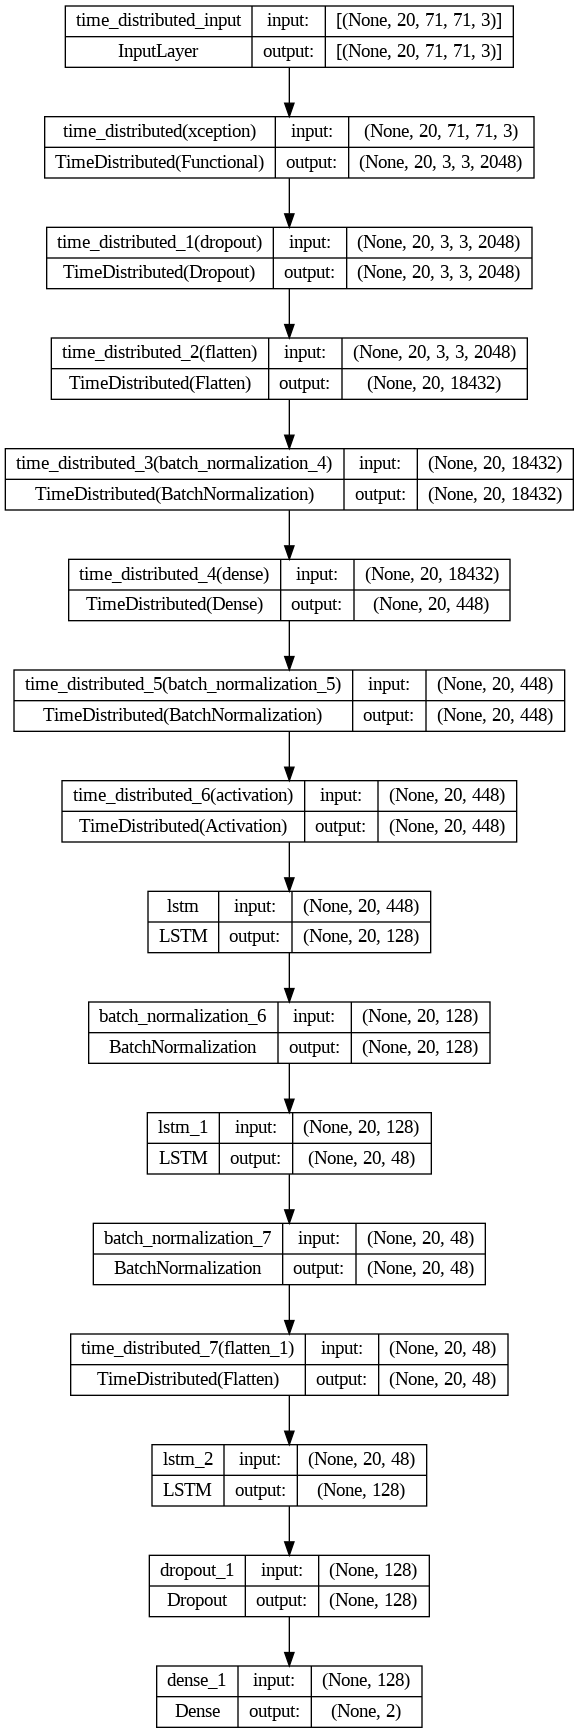

In [10]:
# Model
def create_LRCN_model():
    model = Sequential()

    base_model = Xception(
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
        include_top=False,
        weights="imagenet"
    )
    model.add(TimeDistributed(base_model, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(Dropout(0.4)))
    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dense(448, kernel_initializer='he_uniform', kernel_regularizer=l2(0.01))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))

    model.add(LSTM(128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(48, return_sequences=True))
    model.add(BatchNormalization())


    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(128))

    model.add(Dropout(0.2))

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model

lrcn_model = create_LRCN_model()

# Visualize the model architecture
plot_model(lrcn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [11]:
# creating CustomDataGenerator
class CustomDataGenerator(Sequence):
    def __init__(self, features, labels, batch_size, sequence_length, shuffle=True):
        self.features = features
        self.labels = labels
        self.SEQUENCE_LENGTH = sequence_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.features))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.features) / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size
        batch_features = self.features[self.indexes[start_index:end_index]]
        batch_labels = self.labels[self.indexes[start_index:end_index]]
        return batch_features, batch_labels


In [12]:
# Cross validation
batch_size = 4
n_splits = 3

stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_constant)

training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

for fold_index, (train_indices, val_indices) in enumerate(stratified_kfold.split(features, labels)):
    print(f"Training on Fold {fold_index + 1}")
    features_train, labels_train = features[train_indices], one_hot_encoded_labels[train_indices]
    features_val, labels_val = features[val_indices], one_hot_encoded_labels[val_indices]

    train_data_generator = CustomDataGenerator(features_train, labels_train, SEQUENCE_LENGTH, batch_size, shuffle=True)
    val_data_generator = CustomDataGenerator(features_val, labels_val, SEQUENCE_LENGTH, batch_size)

    LRCN_model = create_LRCN_model()
    LRCN_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=["accuracy"])
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    LRCN_model_training_history = LRCN_model.fit(x=train_data_generator, epochs=10, validation_data=val_data_generator, callbacks=[early_stopping_callback])

    # Evaluating the trained model on validation set
    validation_loss, validation_accuracy = LRCN_model.evaluate(features_val, labels_val)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    # Storing training metrics for the last epoch of each fold
    training_losses.append(LRCN_model_training_history.history['loss'][-1])
    training_accuracies.append(LRCN_model_training_history.history['accuracy'][-1])

# Evaluating on full training set
train_loss, train_accuracy = LRCN_model.evaluate(features_train, labels_train)
training_losses.append(train_loss)
training_accuracies.append(train_accuracy)

# Evaluating on full validation set
val_loss, val_accuracy = LRCN_model.evaluate(features_val, labels_val)
validation_losses.append(val_loss)
validation_accuracies.append(val_accuracy)

# Calculating average training and validation metrics across all folds
avg_training_loss = np.mean(training_losses)
avg_training_accuracy = np.mean(training_accuracies)
avg_validation_loss = np.mean(validation_losses)
avg_validation_accuracy = np.mean(validation_accuracies)

print(f"Average Training Loss: {avg_training_loss:.4f}, Average Training Accuracy: {avg_training_accuracy:.4f}")
print(f"Average Validation Loss: {avg_validation_loss:.4f}, Average Validation Accuracy: {avg_validation_accuracy:.4f}")

# Evaluating the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)


Training on Fold 1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, 20, 3, 3, 2048)    20861480  
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, 20, 3, 3, 2048)    0         
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 20, 18432)         0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 20, 18432)         73728     
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None,

In [ ]:
# Saving the model
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_file_name = f'LRCN_model_{model_evaluation_loss}_{model_evaluation_accuracy}.h5'

save_directory='/content/drive/MyDrive/minor_project_final/final_model_file'

model_file_path = os.path.join(save_directory, model_file_name)
LRCN_model.save(model_file_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
#Loading the model
pretrained_model_path = '/Users/jibanchaudhary/Documents/minor_project_final/model_file/2)LRCN_model_400videos.h5'
LRCN_model = load_model(pretrained_model_path)

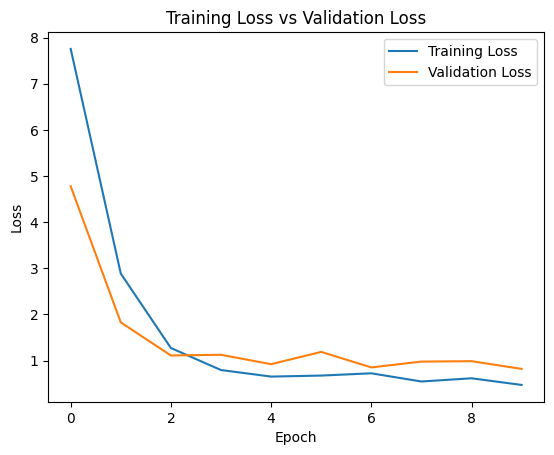

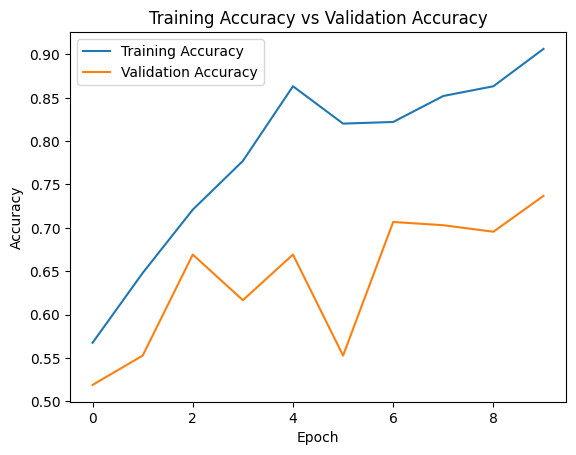

In [13]:
# Visualize the training and validation accuracy metrics.

def plot_metric(history, train_metric, val_metric, metric_name):
    plt.plot(history[train_metric], label=f'Training {metric_name}')
    plt.plot(history[val_metric], label=f'Validation {metric_name}')
    plt.title(f'Training {metric_name} vs Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

history = LRCN_model_training_history.history
plot_metric(history, 'loss', 'val_loss', 'Loss')
plot_metric(history, 'accuracy', 'val_accuracy', 'Accuracy')


In [ ]:
# Testing individual videos
def predict_display(video_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    frames_list = []

    while True:
        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_list.append(normalized_frame)

        if len(frames_list) == SEQUENCE_LENGTH:
            break

    video_reader.release()
    frames_array = np.array(frames_list)
    frames_array = frames_array.reshape(1, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    predicted_labels_probabilities = LRCN_model.predict(frames_array)[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f'Predicted Action: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    # Display the original video
    display_video(video_file_path)

def display_video(video_path):
    # Display the original video
    video = Video(video_path, width=400, embed=True)
    ipythondisplay.display(video)

# Example usage
test_video_path = '/content/drive/MyDrive/test_gauri/real/adohdulfwb.mp4'
SEQUENCE_LENGTH = 20

predict_display(test_video_path, SEQUENCE_LENGTH)

In [9]:
# Testing test dataset
testing_dataset_dir = r'/content/drive/MyDrive/minor_project_final/test'
testing_classes = sorted([class_name for class_name in os.listdir(testing_dataset_dir) if not class_name.startswith('.')], reverse=True)

testing_features = []
testing_labels = []

for class_index, class_name in enumerate(testing_classes):
    print(f'Extracting Data of Class: {class_name}')

    class_path = os.path.join(testing_dataset_dir, class_name)
    files_list = [file_name for file_name in os.listdir(class_path) if not file_name.startswith('.')]

    for file_name in files_list:
        video_file_path = os.path.join(class_path, file_name)
        frames = frames_extraction(video_file_path, augment=False)

        if len(frames) == SEQUENCE_LENGTH:
            testing_features.append(frames)
            testing_labels.append(class_index)

testing_features = np.asarray(testing_features)
testing_labels = np.array(testing_labels)


one_hot_encoded_testing_labels = to_categorical(testing_labels)


model_evaluation_history = LRCN_model.evaluate(testing_features, one_hot_encoded_testing_labels)


model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Print the evaluation results
print(f"Testing Loss: {model_evaluation_loss}")
print(f"Testing Accuracy: {model_evaluation_accuracy}")


Extracting Data of Class: Real
Extracting Data of Class: Fake
2/2 [==============================] - 23s 9s/step - loss: 0.5086 - accuracy: 0.8710
Testing Loss: 0.5086193680763245
Testing Accuracy: 0.8709677457809448
